In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from nltk.stem import SnowballStemmer 
import seaborn as sns
import matplotlib.pyplot as plt

# load the LinearRegression() function from sklearn's 'linear_model' sub-library
from sklearn.linear_model import LogisticRegression
# load the cross_val_score function from the sklearn.model_selection module
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [3]:
df = pd.read_csv('Reviews.csv')
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...


In [4]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568452 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568452 non-null int64
ProductId                 568452 non-null object
UserId                    568452 non-null object
ProfileName               568436 non-null object
HelpfulnessNumerator      568452 non-null int64
HelpfulnessDenominator    568452 non-null int64
Score                     568452 non-null int64
Time                      568452 non-null int64
Summary                   568425 non-null object
Text                      568452 non-null object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [6]:
df.shape

(568452, 10)

In [7]:
df.nunique()

Id                        568452
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295741
Text                      393577
dtype: int64

In [8]:
# rename columns
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

In [9]:
def score_sentiment(score):
    # Replace scores of 1,2 with negative and 4,5 with positive
    if(score <= 3):
        return "negative"
    else:
        return "positive"
df["Sentiment"] = df.Score.apply(score_sentiment)   

In [10]:
df["Sentiment"].value_counts()

positive    443775
negative    124677
Name: Sentiment, dtype: int64

In [11]:
# import re
# from nltk.stem import SnowballStemmer 
snow = SnowballStemmer('english') 

def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out    

In [12]:
df["Cleaned_text"] = df['Text'].apply(cleanup)
df["Cleaned_text"].head()

0    i have bought sever of the vital can dog food product and have found them all to be of good qual...
1    product arriv label as jumbo salt peanut the peanut were actual small size unsalt not sure if th...
2    this is a confect that has been around a few centuri it is a light pillowi citrus gelatin with n...
3    if you are look for the secret ingredi in robitussin i believ i have found it i got this in addi...
4    great taffi at a great price there was a wide assort of yummi taffi deliveri was veri quick if y...
Name: Cleaned_text, dtype: object

Text(0.5, 1.0, 'Bar plot of sentiments')

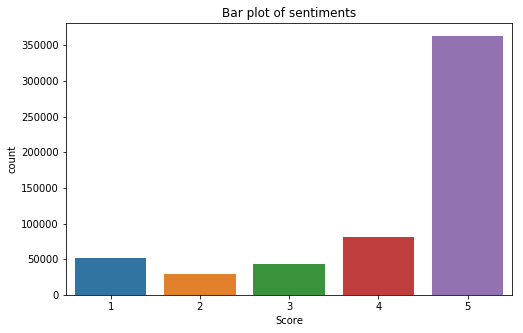

In [13]:
plt.figure(figsize = (8,5))
sns.countplot(df['Score'])
plt.title("Bar plot of sentiments")

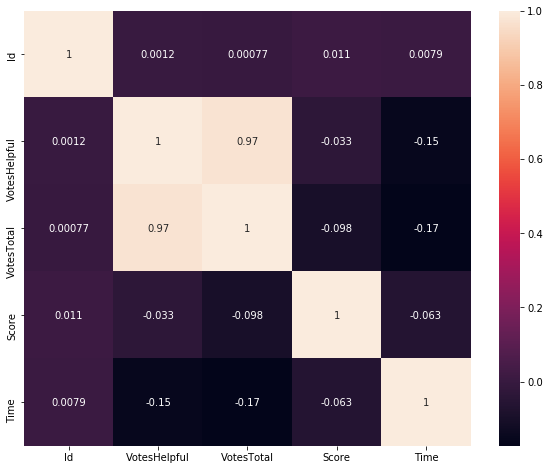

In [14]:
# set figure size
plt.figure(figsize=(10,8))
# give corr value to co
co = df.corr()
# use seaborn to generate heatmap
sns.heatmap(co, annot=True)

In [15]:
df[df['Score']==5][['Summary','Cleaned_text','Sentiment']].head(5)

,Summary,Cleaned_text,Sentiment
0,Good Quality Dog Food,i have bought sever of the vital can dog food product and have found them all to be of good qual...,positive
4,Great taffy,great taffi at a great price there was a wide assort of yummi taffi deliveri was veri quick if y...,positive
6,Great! Just as good as the expensive brands!,this saltwat taffi had great flavor and was veri soft and chewi each candi was individu wrap wel...,positive
7,"Wonderful, tasty taffy",this taffi is so good it is veri soft and chewi the flavor are amaz i would definit recommend yo...,positive
8,Yay Barley,right now im most just sprout this so my cat can eat the grass they love it i rotat it around wi...,positive


In [16]:
df[df['Score']==1][['Summary','Cleaned_text','Sentiment']].head(5)

,Summary,Cleaned_text,Sentiment
1,Not as Advertised,product arriv label as jumbo salt peanut the peanut were actual small size unsalt not sure if th...,negative
12,My Cats Are Not Fans of the New Food,my cat have been happili eat felida platinum for more than two year i just got a new bag and the...,negative
26,Nasty No flavor,the candi is just red no flavor just plan and chewi i would never buy them again,negative
50,Don't like it,this oatmeal is not good it mushi soft i dont like it quaker oat is the way to go,negative
62,stale product.,arriv in 6 day and were so stale i could not eat ani of the 6 bag,negative


In [17]:
df.shape

(568452, 12)

In [18]:
X = df['Cleaned_text']
y = df['Sentiment']

In [19]:
# fit method
def text_fit(X, y, model,ml_model):
    
    X_c = model.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    ml = ml_model.fit(X_train, y_train)
    
    y_pred = ml_model.predict(X_test)
    print("accuracy score: ",accuracy_score(y_test, y_pred))
    auc=roc_auc_score(y_test, ml_model.predict_proba(X_test)[:,1])
    print("AUC score",auc)
    print('')
    print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))


### LogisticRegression L1

In [20]:
# LogisticRegression on Uni-gram BoW
model = CountVectorizer()   
text_fit(X, y, model, LogisticRegression(penalty='l1'))

accuracy score:  0.9014727716676166
AUC score 0.9336926549752885

              precision    recall  f1-score   support

    negative       0.82      0.70      0.76     30967
    positive       0.92      0.96      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.87      0.83      0.85    142113
weighted avg       0.90      0.90      0.90    142113



In [21]:
# LogisticRegression on Bi-gram BoW
c = CountVectorizer(ngram_range=(1,2),min_df = 5)
text_fit(X, y, c, LogisticRegression(penalty='l1'))

accuracy score:  0.9403432479787212
AUC score 0.964841118779135

              precision    recall  f1-score   support

    negative       0.88      0.84      0.86     30967
    positive       0.96      0.97      0.96    111146

   micro avg       0.94      0.94      0.94    142113
   macro avg       0.92      0.91      0.91    142113
weighted avg       0.94      0.94      0.94    142113



In [22]:
# Logistic regression model on TFIDF
tfidf = TfidfVectorizer()
text_fit(X, y, tfidf, LogisticRegression(penalty='l1'))

accuracy score:  0.898651073441557
AUC score 0.9411308026694285

              precision    recall  f1-score   support

    negative       0.81      0.70      0.75     30967
    positive       0.92      0.95      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.87      0.83      0.84    142113
weighted avg       0.90      0.90      0.90    142113



In [23]:
#Logistic regression model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2))
text_fit(X, y, tfidf_n, LogisticRegression(penalty='l1'))

accuracy score:  0.9264247465045422
AUC score 0.9659925989652527

              precision    recall  f1-score   support

    negative       0.87      0.78      0.82     30967
    positive       0.94      0.97      0.95    111146

   micro avg       0.93      0.93      0.93    142113
   macro avg       0.91      0.87      0.89    142113
weighted avg       0.92      0.93      0.92    142113



### LogisticRegression L2

In [24]:
# LogisticRegression on Uni-gram BoW
model = CountVectorizer()   
text_fit(X, y, model, LogisticRegression())

/Users/TTzuo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy score:  0.9011279756250308
AUC score 0.9344591832168638

              precision    recall  f1-score   support

    negative       0.82      0.70      0.76     30967
    positive       0.92      0.96      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.87      0.83      0.85    142113
weighted avg       0.90      0.90      0.90    142113



In [25]:
# LogisticRegression on Bi-gram BoW
c = CountVectorizer(ngram_range=(1,2),min_df = 5)
text_fit(X, y, c, LogisticRegression())

accuracy score:  0.9447270833773124
AUC score 0.969518527797378

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87     30967
    positive       0.96      0.97      0.96    111146

   micro avg       0.94      0.94      0.94    142113
   macro avg       0.92      0.91      0.92    142113
weighted avg       0.94      0.94      0.94    142113



In [26]:
# Logistic regression model on TFIDF
tfidf = TfidfVectorizer()
text_fit(X, y, tfidf, LogisticRegression())

accuracy score:  0.8985736702483235
AUC score 0.9419280011171592

              precision    recall  f1-score   support

    negative       0.82      0.69      0.75     30967
    positive       0.92      0.96      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.87      0.82      0.84    142113
weighted avg       0.90      0.90      0.90    142113



In [27]:
#Logistic regression model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2))
text_fit(X, y, tfidf_n, LogisticRegression())

accuracy score:  0.9323777557295955
AUC score 0.9719637406896504

              precision    recall  f1-score   support

    negative       0.90      0.78      0.83     30967
    positive       0.94      0.98      0.96    111146

   micro avg       0.93      0.93      0.93    142113
   macro avg       0.92      0.88      0.90    142113
weighted avg       0.93      0.93      0.93    142113



### RandomForest

In [28]:
# RandomForest with Uni-gram BoW and stop_words
model = CountVectorizer(stop_words = 'english')   
text_fit(X, y, model, RandomForestClassifier())

accuracy score:  0.8957449353683337
AUC score 0.9287937182357736

              precision    recall  f1-score   support

    negative       0.85      0.64      0.73     30967
    positive       0.91      0.97      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.88      0.80      0.83    142113
weighted avg       0.89      0.90      0.89    142113



In [29]:
# RandomForest with n-gram BoW and stop words
model = CountVectorizer(ngram_range=(1,2),stop_words = 'english')   
text_fit(X, y, model, RandomForestClassifier())

accuracy score:  0.89523125963142
AUC score 0.9258247536649956

              precision    recall  f1-score   support

    negative       0.91      0.57      0.70     30967
    positive       0.89      0.98      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.90      0.78      0.82    142113
weighted avg       0.90      0.90      0.89    142113



In [30]:
# RandomForest model on TFIDF with stop words
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, RandomForestClassifier())

accuracy score:  0.8950060867056497
AUC score 0.9256710048839544

              precision    recall  f1-score   support

    negative       0.87      0.61      0.72     30967
    positive       0.90      0.97      0.94    111146

   micro avg       0.90      0.90      0.90    142113
   macro avg       0.88      0.79      0.83    142113
weighted avg       0.89      0.90      0.89    142113



In [31]:
#RandomForest model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, RandomForestClassifier())

accuracy score:  0.8937324523442612
AUC score 0.9225352007835864

              precision    recall  f1-score   support

    negative       0.93      0.55      0.69     30967
    positive       0.89      0.99      0.94    111146

   micro avg       0.89      0.89      0.89    142113
   macro avg       0.91      0.77      0.82    142113
weighted avg       0.90      0.89      0.88    142113



### KNeighbors

In [32]:
# KNeighbors model with Uni-gram BoW
c = CountVectorizer()
text_fit(X, y, c, KNeighborsClassifier())

accuracy score:  0.8451091736857289
AUC score 0.82035035225051

              precision    recall  f1-score   support

    negative       0.76      0.42      0.54     30967
    positive       0.86      0.96      0.91    111146

   micro avg       0.85      0.85      0.85    142113
   macro avg       0.81      0.69      0.72    142113
weighted avg       0.84      0.85      0.83    142113



In [33]:
# KNeighbors model with n-gram BoW
c = CountVectorizer(ngram_range=(1,2))
text_fit(X, y, c, KNeighborsClassifier())

accuracy score:  0.8414219670262397
AUC score 0.7938102860508853

              precision    recall  f1-score   support

    negative       0.80      0.37      0.50     30967
    positive       0.85      0.97      0.91    111146

   micro avg       0.84      0.84      0.84    142113
   macro avg       0.82      0.67      0.70    142113
weighted avg       0.84      0.84      0.82    142113



In [34]:
# KNeighbors model on TFIDF 
tfidf = TfidfVectorizer()
text_fit(X, y, tfidf, KNeighborsClassifier())

accuracy score:  0.8302899805084686
AUC score 0.7128651294616299

              precision    recall  f1-score   support

    negative       0.89      0.25      0.39     30967
    positive       0.83      0.99      0.90    111146

   micro avg       0.83      0.83      0.83    142113
   macro avg       0.86      0.62      0.65    142113
weighted avg       0.84      0.83      0.79    142113



In [35]:
#KNeighbors model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2))
text_fit(X, y, tfidf_n, KNeighborsClassifier())

accuracy score:  0.829579278461506
AUC score 0.6961031661704881

              precision    recall  f1-score   support

    negative       1.00      0.22      0.36     30967
    positive       0.82      1.00      0.90    111146

   micro avg       0.83      0.83      0.83    142113
   macro avg       0.91      0.61      0.63    142113
weighted avg       0.86      0.83      0.78    142113



### Naive bayes MultinomialNB

In [36]:
#MultinomialNB model with bow
c = CountVectorizer()
text_fit(X, y, c, MultinomialNB())

accuracy score:  0.8706733374145926
AUC score 0.9051106517961698

              precision    recall  f1-score   support

    negative       0.70      0.72      0.71     30967
    positive       0.92      0.91      0.92    111146

   micro avg       0.87      0.87      0.87    142113
   macro avg       0.81      0.82      0.81    142113
weighted avg       0.87      0.87      0.87    142113



In [37]:
#MultinomialNB model with n-gram
tfidf_n = CountVectorizer(ngram_range=(1,2))
text_fit(X, y, tfidf_n, MultinomialNB())


accuracy score:  0.9193669826124281
AUC score 0.948792648424118

              precision    recall  f1-score   support

    negative       0.83      0.79      0.81     30967
    positive       0.94      0.96      0.95    111146

   micro avg       0.92      0.92      0.92    142113
   macro avg       0.89      0.87      0.88    142113
weighted avg       0.92      0.92      0.92    142113



## Conclusion
The best model in this case is Logistic Regression L2 on Bi-gram model, the accuracy score is 94.5%, AUC score is 97%, f1 score is 94%